In [17]:
import numpy as np
import random
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm.autonotebook import tqdm

In [18]:
def read_fits_file(file_name):
    fits_file = fits.open(file_name)
    data = fits_file["PRIMARY"].data
    return data

def create_fits_file(filename,array):
    hdu = fits.PrimaryHDU(array)
    hdu.writeto(filename,overwrite=True)

In [19]:
ANNO_FILE_PATH = "lens_finding/SpaceBasedTraining/classifications.csv"
IMG_DIR = "lens_finding/SpaceBasedTraining/files"

In [20]:
annotations = pd.read_csv(ANNO_FILE_PATH)
anno_no_lens = annotations.loc[annotations["is_lens"] == 0]

In [21]:
image_list = [f"{IMG_DIR}/imageEUC_VIS-{x}.fits" for x in anno_no_lens["ID"].to_list()]

In [22]:
def load_random_images(file_list,no_load=4):
    selected_files = random.choices(file_list,k=no_load)
    for i,__file in enumerate(selected_files):
        selected_files[i] = read_fits_file(__file)
        
    return selected_files

def tile_images(images,rows=2,columns=2):
    assert len(images) == rows*columns
    
    H,W = images[0].shape
    
    tiled = np.zeros((H*rows,W*columns))
    for i in range(rows):
        for j in range(columns):
            tiled[H*i:H*(i+1),W*j:W*(j+1)] = images[rows*i+j]
    
    del images
    return tiled

def generate_new_image(file_list,rows=2,columns=2):
    loaded_images = load_random_images(file_list=file_list,no_load=rows*columns)
    tiled = tile_images(loaded_images,rows=rows,columns=columns)
    tiled = cv.resize(tiled,(101,101))
    return tiled

def add_image(image_list,entry_id):
    image = generate_new_image(image_list)
    file_path = f"{IMG_DIR}/imageEUC_VIS-{entry_id}.fits"
    create_fits_file(file_path,image)
    
    return entry_id,file_path,0
    

In [23]:
image = generate_new_image(image_list)

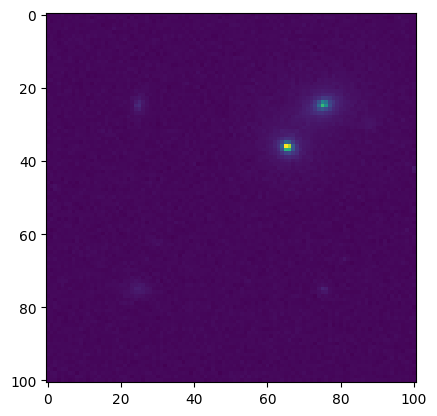

In [24]:
plt.imshow(image)

In [25]:
max_id = annotations["ID"].max()

In [26]:
annotations["is_lens"].value_counts()

1    12574
0     5426
Name: is_lens, dtype: int64

In [27]:
12574-5426

7148

In [29]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

#for each_file in tqdm(files,desc="Files Used",total=len(files)):
with ThreadPoolExecutor() as executor:
    file_loc = list(tqdm(executor.map(partial(add_image,image_list),range(max_id+1,max_id+7148+1)), total=7148,desc="Processed Files:"))

Processed Files::   0%|          | 0/7148 [00:00<?, ?it/s]

In [32]:
annotations

,ID,is_lens,Einstein_area,numb_pix_lensed_image,flux_lensed_image_in_sigma
0,100000,1,8.633760e-10,171,195.4290
1,100001,1,1.317890e-10,294,855.5890
2,100002,1,4.877250e-12,140,486.1130
3,100003,1,1.440160e-09,1500,10467.4000
4,100004,0,2.197350e-11,0,0.0000
...,...,...,...,...,...
17995,117995,1,4.428430e-11,35,68.9357
17996,117996,0,1.937930e-11,0,0.0000
17997,117997,1,5.505060e-11,520,1145.4500
17998,117998,1,9.624780e-12,109,434.6310


In [33]:
for f_id, f_loc,label in tqdm(file_loc):
    annotations.loc[len(annotations.index)] = [f_id,label,"gen","gen","gen"]

In [34]:
annotations.to_csv("lens_finding/SpaceBasedTraining/classifications_augmented.csv",index=False)

In [35]:
pd.read_csv("lens_finding/SpaceBasedTraining/classifications_augmented.csv")["is_lens"].value_counts()

1    12574
0    12574
Name: is_lens, dtype: int64